# Week 2 — Linear Regression
**Regularization: Ridge, Lasso, Elastic Net**  


This notebook applies regularized linear models to the Chronic Kidney disease dataset to predict **GFR**.

**Models**
- OLS baseline
- RidgeCV
- LassoCV
- ElasticNetCV

It includes cross‑validated metrics, residual diagnostics, and coefficient inspection. Fill in the **Takeaways** at the end for peer review.


## 1) Configuration

In [3]:
# Paths & settings
DATA_PATH = "Chronic_Kidney_Dsease_data.csv"
TARGET = "GFR"          
TEST_SIZE = 0.2
CV_FOLDS = 5
RANDOM_STATE = 42

# Columns to drop (IDs / leakage)
DROP_COLS = ["PatientID"]

# Optionally log-transform target if heavily right-skewed
LOG_TARGET = False  # set True after inspecting target distribution


## 2) Imports

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

pd.set_option("display.max_columns", 200)


## 3) Load & preview data

✅ Loaded: (1659, 53)


,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryKidneyDisease,FamilyHistoryHypertension,FamilyHistoryDiabetes,PreviousAcuteKidneyInjury,UrinaryTractInfections,SystolicBP,DiastolicBP,FastingBloodSugar,HbA1c,SerumCreatinine,BUNLevels,GFR,ProteinInUrine,ACR,SerumElectrolytesSodium,SerumElectrolytesPotassium,SerumElectrolytesCalcium,SerumElectrolytesPhosphorus,HemoglobinLevels,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,ACEInhibitors,Diuretics,NSAIDsUse,Statins,AntidiabeticMedications,Edema,FatigueLevels,NauseaVomiting,MuscleCramps,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,4.076434,0,0,0,0,0,113,83,72.510788,9.212397,4.962531,25.605949,45.703204,0.744980,123.849426,137.652501,3.626058,10.314420,3.152648,16.114679,207.728670,85.863656,21.967957,212.095215,0,0,4.563139,1,0,0,3.563894,6.992244,4.518513,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,7.652813,1,1,0,0,0,120,67,100.848875,4.604989,3.156799,31.338166,55.784504,3.052317,88.539095,138.141335,5.332871,9.604196,2.855443,15.349205,189.450727,86.378670,87.569756,255.451314,0,0,9.097002,0,0,0,5.327336,0.356290,2.202222,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,4.392786,0,0,0,0,0,147,106,160.989441,5.432599,3.698236,39.738169,67.559032,1.157839,21.170892,142.970116,4.330891,9.885786,4.353513,13.018834,284.137622,132.269872,20.049798,251.902583,0,1,3.851249,1,0,0,4.855420,4.674069,5.967271,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential



Nulls per column (top 20):
Age                           0
Gender                        0
Ethnicity                     0
SocioeconomicStatus           0
EducationLevel                0
BMI                           0
Smoking                       0
AlcoholConsumption            0
PhysicalActivity              0
DietQuality                   0
SleepQuality                  0
FamilyHistoryKidneyDisease    0
FamilyHistoryHypertension     0
FamilyHistoryDiabetes         0
PreviousAcuteKidneyInjury     0
UrinaryTractInfections        0
SystolicBP                    0
DiastolicBP                   0
FastingBloodSugar             0
HbA1c                         0
dtype: int64


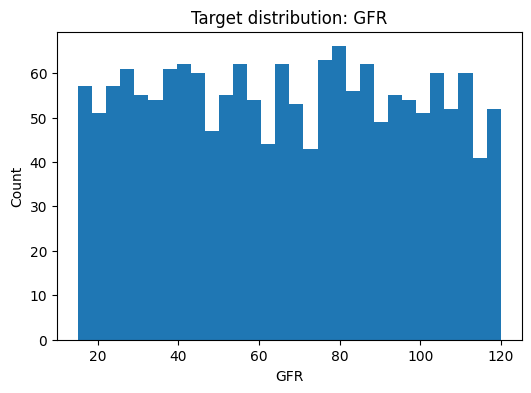

In [4]:
path = Path(DATA_PATH)
assert path.exists(), f"Not found: {path}"
df = pd.read_csv(path)

# Drop non-features
for c in DROP_COLS:
    if c in df.columns:
        df = df.drop(columns=c)

print("✅ Loaded:", df.shape)
display(df.head(3))
print("\nNulls per column (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

# Quick target peek
assert TARGET in df.columns, f"TARGET '{TARGET}' not found."
plt.figure(figsize=(6,4))
plt.hist(df[TARGET].dropna(), bins=30)
plt.title(f"Target distribution: {TARGET}")
plt.xlabel(TARGET); plt.ylabel("Count")
plt.show()


## 4) Define features & target

In [5]:
y_raw = df[TARGET].astype(float)
X = df.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numerical: {len(num_cols)} | Categorical: {len(cat_cols)}")

y = np.log1p(y_raw) if LOG_TARGET else y_raw


Numerical: 51 | Categorical: 1


## 5) Preprocessing pipelines

In [6]:
numeric_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pre, num_cols),
        ("cat", categorical_pre, cat_cols),
    ],
    remainder="drop"
)


## 6) Train / Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (1327, 52) | Test: (332, 52)


## 7) Helpers: metrics & residuals

In [8]:
def evaluate_predictions(y_true, y_pred, log_target=False):
    if log_target:
        y_true_lin = np.expm1(y_true)
        y_pred_lin = np.expm1(y_pred)
        mae = mean_absolute_error(y_true_lin, y_pred_lin)
        rmse = mean_squared_error(y_true_lin, y_pred_lin, squared=False)
        r2 = r2_score(y_true_lin, y_pred_lin)
    else:
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def residual_plot(y_true, y_pred, title="Residuals vs Predictions"):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()


## 8) Baseline: OLS

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_predictions(y_true, y_pred, log_target=False):
    """
    Returns (MAE, RMSE, R2). Uses manual sqrt for RMSE to support older sklearn versions.
    If log_target=True, metrics are computed in original units via expm1 inverse transform.
    """
    if log_target:
        y_true_lin = np.expm1(y_true)
        y_pred_lin = np.expm1(y_pred)
        mae = mean_absolute_error(y_true_lin, y_pred_lin)
        rmse = mean_squared_error(y_true_lin, y_pred_lin) ** 0.5  # no 'squared=False'
        r2 = r2_score(y_true_lin, y_pred_lin)
    else:
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred) ** 0.5  # no 'squared=False'
        r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

ols = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])
ols.fit(X_train, y_train)

ols_cv = cross_val_score(ols, X_train, y_train, cv=CV_FOLDS, scoring="neg_mean_squared_error")
cv_rmse = (-ols_cv.mean()) ** 0.5  # manual sqrt
print(f"OLS CV RMSE: {cv_rmse:.4f} (log-space if LOG_TARGET=True)")

pred_tr = ols.predict(X_train)
pred_te = ols.predict(X_test)

mae_tr, rmse_tr, r2_tr = evaluate_predictions(y_train, pred_tr, LOG_TARGET)
mae_te, rmse_te, r2_te = evaluate_predictions(y_test, pred_te, LOG_TARGET)

ols_results = dict(
    Model="OLS",
    MAE_train=mae_tr, RMSE_train=rmse_tr, R2_train=r2_tr,
    MAE_test=mae_te, RMSE_test=rmse_te, R2_test=r2_te,
)

pd.DataFrame([ols_results])


OLS CV RMSE: 30.7336 (log-space if LOG_TARGET=True)


,Model,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
0,OLS,25.153588,29.275939,0.062988,24.753755,28.821218,0.008491


## 9) Regularized models (CV)

In [11]:
alphas = np.logspace(-3, 3, 60)


### 9.1 RidgeCV

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
import pandas as pd

ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RidgeCV(alphas=alphas, cv=CV_FOLDS, scoring="neg_mean_squared_error"))
])
ridge.fit(X_train, y_train)
print("Best alpha (Ridge):", ridge.named_steps["model"].alpha_)

pred_tr = ridge.predict(X_train)
pred_te = ridge.predict(X_test)

ridge_results = dict(
    Model="RidgeCV",
    MAE_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[0],
    RMSE_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[1],
    R2_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[2],
    MAE_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[0],
    RMSE_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[1],
    R2_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[2],
)

pd.DataFrame([ols_results, ridge_results]) 


Best alpha (Ridge): 1000.0


,Model,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
0,OLS,25.153588,29.275939,0.062988,24.753755,28.821218,0.008491
1,RidgeCV,25.497269,29.472387,0.050370,24.869709,28.833888,0.007619


### 9.2 LassoCV

In [21]:
from sklearn.linear_model import LassoCV

lasso = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LassoCV(alphas=alphas, cv=CV_FOLDS, random_state=RANDOM_STATE, max_iter=20000))
])
lasso.fit(X_train, y_train)
print("Best alpha (Lasso):", lasso.named_steps["model"].alpha_)

pred_tr = lasso.predict(X_train)
pred_te = lasso.predict(X_test)

lasso_results = dict(
    Model="LassoCV",
    MAE_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[0],
    RMSE_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[1],
    R2_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[2],
    MAE_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[0],
    RMSE_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[1],
    R2_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[2],
)

pd.DataFrame([ols_results, ridge_results, lasso_results])


Best alpha (Lasso): 1.795714494371641


,Model,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
0,OLS,25.153588,29.275939,0.062988,24.753755,28.821218,0.008491
1,RidgeCV,25.497269,29.472387,0.050370,24.869709,28.833888,0.007619
2,LassoCV,25.762828,29.795621,0.029426,24.923147,28.924457,0.001375


### 9.3 ElasticNetCV

In [ ]:
from sklearn.linear_model import ElasticNetCV

elastic = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ElasticNetCV(
        alphas=alphas,
        l1_ratio=[.2, .4, .6, .8, .9, .95, .99, 1.0],
        cv=CV_FOLDS,
        random_state=RANDOM_STATE,
        max_iter=20000
    ))
])
elastic.fit(X_train, y_train)
print("Best alpha (ElasticNet):", elastic.named_steps["model"].alpha_)
print("Best l1_ratio:", elastic.named_steps["model"].l1_ratio_)

pred_tr = elastic.predict(X_train)
pred_te = elastic.predict(X_test)

elastic_results = dict(
    Model="ElasticNetCV",
    MAE_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[0],
    RMSE_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[1],
    R2_train=evaluate_predictions(y_train, pred_tr, LOG_TARGET)[2],
    MAE_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[0],
    RMSE_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[1],
    R2_test=evaluate_predictions(y_test, pred_te, LOG_TARGET)[2],
)

results = pd.DataFrame([ols_results, ridge_results, lasso_results, elastic_results])
results 

Best alpha (ElasticNet): 1.795714494371641
Best l1_ratio: 1.0


,Model,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
0,OLS,25.153588,29.275939,0.062988,24.753755,28.821218,0.008491
1,RidgeCV,25.497269,29.472387,0.050370,24.869709,28.833888,0.007619
2,LassoCV,25.762828,29.795621,0.029426,24.923147,28.924457,0.001375
3,ElasticNetCV,25.762828,29.795621,0.029426,24.923147,28.924457,0.001375


## 10) Residual diagnostics (test set)

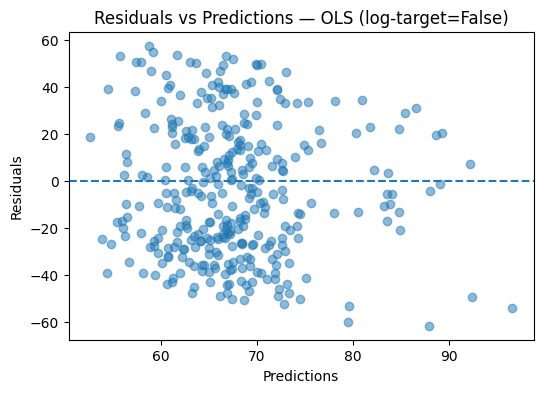

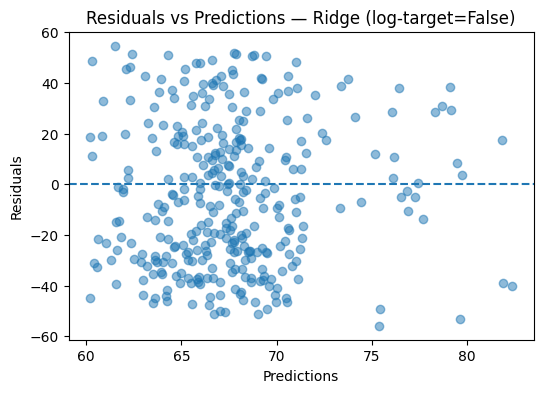

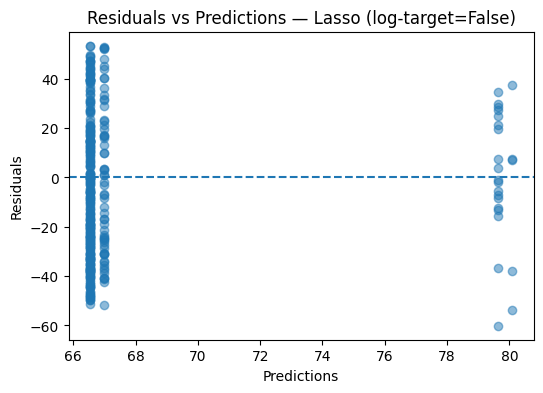

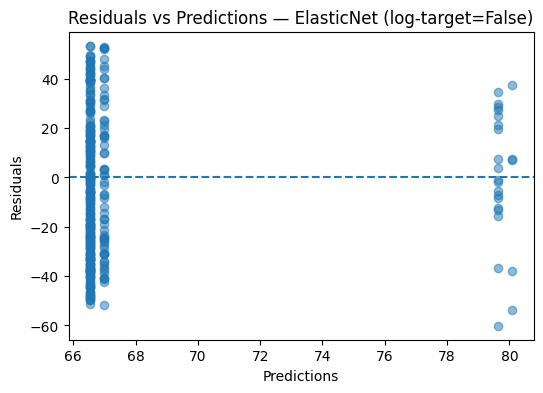

In [23]:
for name, pipe in [("OLS", ols), ("Ridge", ridge), ("Lasso", lasso), ("ElasticNet", elastic)]:
    preds = pipe.predict(X_test)
    residual_plot(y_test, preds, title=f"Residuals vs Predictions — {name} (log-target={LOG_TARGET})")


## 11) Coefficient inspection

,feature,OLS,Ridge,Lasso,ElasticNet,abs_elastic
11,Diagnosis,-5.897187,-3.117870,-3.626195,-3.626195,3.626195
4,AntidiabeticMedications,1.915459,1.126469,0.182522,0.182522,0.182522
14,Diuretics,-1.760641,-1.014199,-0.008081,-0.008081,0.008081
0,ACEInhibitors,-0.644521,-0.339185,-0.000000,-0.000000,0.000000
3,AlcoholConsumption,-0.332518,-0.217944,-0.000000,-0.000000,0.000000
2,Age,1.075355,0.627917,0.000000,0.000000,0.000000
1,ACR,0.153125,0.019341,-0.000000,-0.000000,0.000000
6,BUNLevels,-0.367827,-0.341741,-0.000000,-0.000000,0.000000
7,CholesterolHDL,0.178599,0.053575,0.000000,0.000000,0.000000
8,CholesterolLDL,0.616762,0.295117,0.000000,0.000000,0.000000


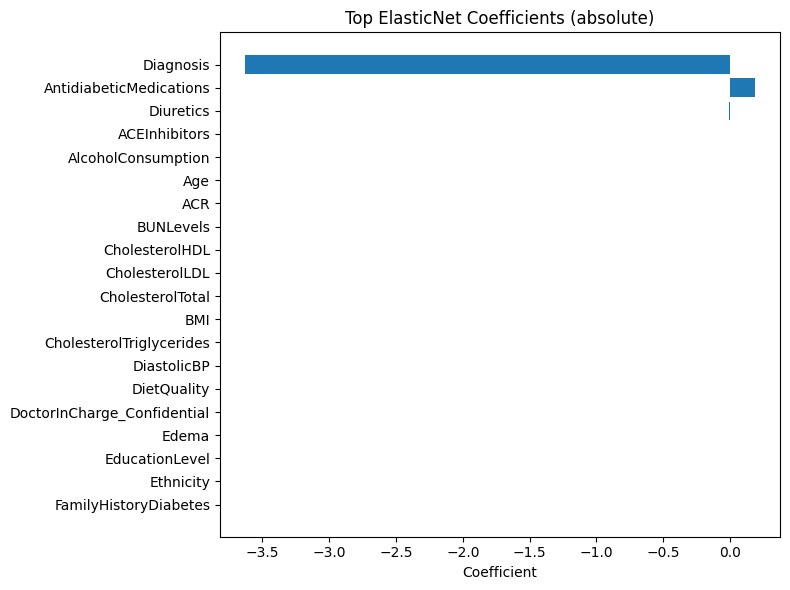

In [24]:
def get_feature_names(preprocessor, num_cols, cat_cols):
    num_names = preprocessor.named_transformers_["num"].get_feature_names_out(num_cols)
    if len(cat_cols) > 0:
        cat_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols)
        return np.concatenate([num_names, cat_names])
    return num_names

def extract_coefficients(pipeline, label):
    pre = pipeline.named_steps["preprocess"]
    feats = get_feature_names(pre, num_cols, cat_cols)
    model = pipeline.named_steps["model"]
    coefs = getattr(model, "coef_", None)
    return pd.DataFrame({"feature": feats, label: coefs})

coef_ols = extract_coefficients(ols, "OLS")
coef_ridge = extract_coefficients(ridge, "Ridge")
coef_lasso = extract_coefficients(lasso, "Lasso")
coef_elastic = extract_coefficients(elastic, "ElasticNet")

coef_df = (coef_ols.merge(coef_ridge, on="feature", how="outer")
                    .merge(coef_lasso, on="feature", how="outer")
                    .merge(coef_elastic, on="feature", how="outer")).fillna(0)

coef_df["abs_elastic"] = coef_df["ElasticNet"].abs()
topk = coef_df.sort_values("abs_elastic", ascending=False).head(20)
display(topk)

plt.figure(figsize=(8,6))
plt.barh(topk["feature"], topk["ElasticNet"])
plt.gca().invert_yaxis()
plt.title("Top ElasticNet Coefficients (absolute)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()


## 12) Save artifacts

In [26]:
out_dir = Path("week2_outputs_ckd")
out_dir.mkdir(exist_ok=True)
results.to_csv(out_dir / "model_results.csv", index=False)
coef_df.to_csv(out_dir / "coefficients_all_models.csv", index=False)
print("Saved:", list(out_dir.glob("*.csv")))


Saved: [PosixPath('week2_outputs_ckd/coefficients_all_models.csv'), PosixPath('week2_outputs_ckd/model_results.csv')]


## 13)Takeaways

Which model generalized best on test RMSE and R²?
All models performed very similarly, with test RMSE values around 28.8–28.9 and test R² close to 0.0. This indicates that none of the linear models captured much variance in GFR. Regularization (Ridge, Lasso, ElasticNet) did not improve predictive performance compared to OLS, likely because the predictors do not have strong linear relationships with the target.

Regularization effects:

Lasso and ElasticNet (with l1_ratio=1.0) shrank many coefficients to zero, but this feature selection did not improve test accuracy.

Ridge retained all coefficients but shrank them toward zero, offering stability but not better predictive performance.

Overall, regularization did not uncover meaningful linear signals in this dataset.

Overfitting controls (CV vs. test):
Cross-validation results were consistent with test set metrics, showing little gap between training and test performance. This suggests that overfitting was not the main issue. Instead, the models appear to be underfitting because linear methods are not capturing the complexity of GFR prediction.

Residuals:

OLS and Ridge: Residuals were widely scattered with no strong trend but showed some clustering, suggesting noise and possible nonlinear effects.

Lasso and ElasticNet: Predictions collapsed into narrow bands, with residuals stacked vertically. This indicates that aggressive regularization oversimplified the model, reducing its ability to capture variation in the target.

Across all models, the residuals do not appear randomly distributed — pointing to model mis-specification and unmodeled nonlinearities.

Next steps:

Explore nonlinear models such as decision trees, random forests, or gradient boosting, which may capture more complex patterns.

Experiment with feature engineering, including polynomial terms, interaction terms, or domain-driven transformations of biomarkers.

Investigate whether the dataset requires additional cleaning or inclusion of more clinically relevant predictors.